In [1]:
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg
import matplotlib.pyplot as plt
import math
import cv2
import pandas as pd

# Manual registration based on origins

In [ ]:
us_path = Path(r'F:\Research\LINK\Mouse data\2019-02-15\Run-2\Output', 'fused_tp_0_ch_0.tif')
shg_path = Path(r'F:\Research\LINK\Mouse data\2019-02-15', '8x fused shg.tif')

In [ ]:
us_image = sitk.ReadImage(str(us_path))
us_image.SetSpacing([46.2022, 46.2022, 46.2022])
shg_image = sitk.ReadImage(str(shg_path))
shg_image.SetSpacing([4.08, 4.08,  4.08])

In [ ]:
us_image_windowed = sitk.IntensityWindowing(us_image, 100, 160)
us_array = sitk.GetArrayFromImage(us_image_windowed)
us_array_rotated = np.swapaxes(us_array, 0, 1)
us_array_rotated = np.flip(us_array_rotated, 0)
us_image_rotated = sitk.GetImageFromArray(us_array_rotated)
us_image_rotated.SetSpacing(us_image.GetSpacing())

In [ ]:
iplt.MultiImageDisplay(image_list=[us_image_rotated, shg_image])

In [ ]:
# -1481 because I measured the 3mm high fiducial as being 4481 from the bottom of the image.
shg_origin = [-3605.1585, -5063, 0]
us_origin = [-9967-3941, -10033.16-1826, -1481]

us_image_rotated.SetOrigin(us_origin)
shg_image.SetOrigin(shg_origin)

In [ ]:
shg_resampled = sitk.Resample(shg_image, us_image_rotated, sitk.AffineTransform(3), sitk.sitkNearestNeighbor, 0.0, shg_image.GetPixelID())

In [ ]:
shg_image.GetDirection()

In [ ]:
iplt.MultiImageDisplay(image_list=[us_image_rotated, shg_resampled])

# Registration based on circles

In [2]:
us_path2 = Path(r'F:\Research\LINK\Phantom Trials\2019-04-04\Fiducial sens0 v8-6','fused_tp_0_ch_0.tif')
mpm_path = Path(r'F:\Research\LINK\Phantom Trials\2019-04-04', 'Fiducial 5deg_8x.tif')

In [3]:
def draw_circles(arr, circles):
    cimg = cv2.cvtColor(arr, cv2.COLOR_GRAY2BGR)
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
    # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
    return cimg
# cv2.imshow('detected circles',cimg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

def draw_lines(arr, lines):
    cimg = cv2.cvtColor(arr, cv2.COLOR_GRAY2BGR)
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(cimg, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
        return cimg
    return arr

In [4]:
us_image2 = sitk.ReadImage(str(us_path2))
mpm_image = sitk.ReadImage(str(mpm_path))
mpm_image.SetSpacing([8.16, 8.16, 25])

In [5]:
us_image2_windowed = sitk.IntensityWindowing(us_image2, 115, 165)
arr2 = sitk.GetArrayFromImage(us_image2_windowed)
arr2_rot = np.swapaxes(arr2, 0, 1)
arr2_rot = np.flip(arr2_rot, 0).astype(np.uint8)
us_fid = sitk.GetImageFromArray(arr2_rot)
us_fid.SetSpacing([25, 25, 25])

In [6]:
mpm_image.SetOrigin([-9038, -9289, 0])
us_fid.SetOrigin([-9967, -10033.16, 0])

In [7]:
mpm_image_windowed = sitk.IntensityWindowing(mpm_image, 0, 40)
mpm_arr = sitk.GetArrayFromImage(mpm_image_windowed).astype(np.uint8)

Box(children=(IntSlider(value=192, description='image slice:', max=385), IntSlider(value=1, description='image…

<IPython.core.display.Javascript object>


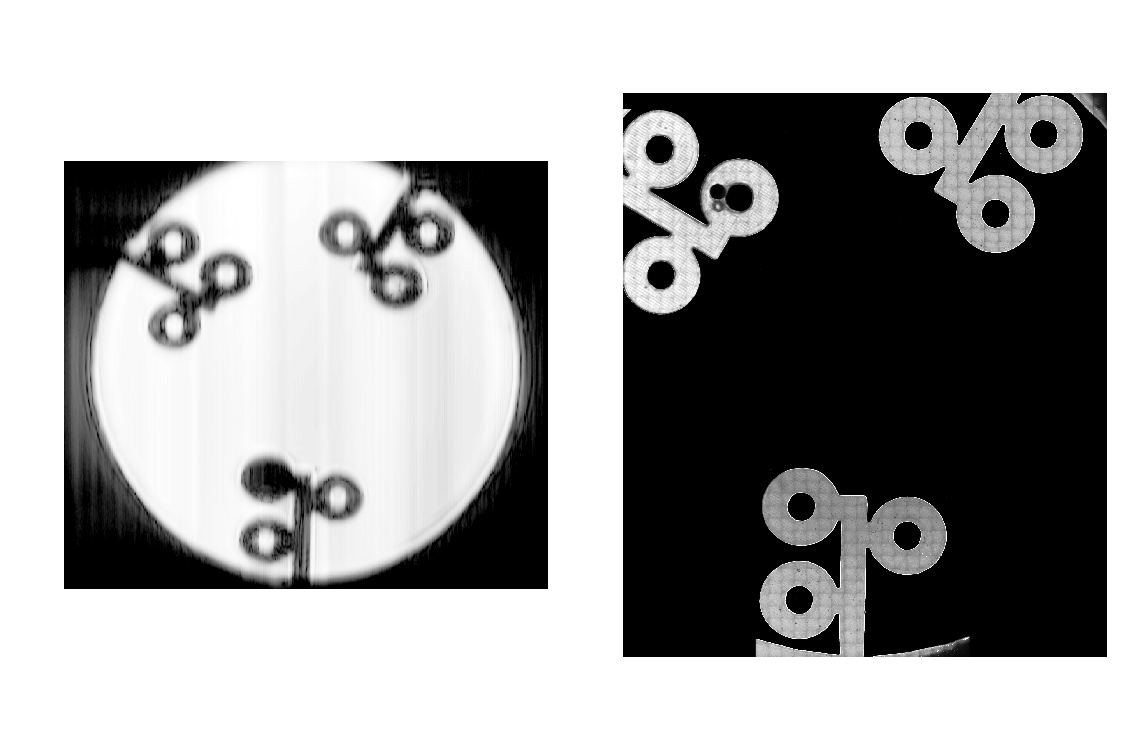

In [8]:
iplt.MultiImageDisplay(image_list=[us_fid, mpm_image_windowed])

In [ ]:
circles = cv2.HoughCircles(mpm_arr[3], cv2.HOUGH_GRADIENT, 1, 50, minRadius=50, maxRadius=80, param2=50)
cimg = draw_circles(mpm_arr[3], circles)
plt.imshow(cimg)

In [ ]:
plt.imshow(arr2_rot[12])

<IPython.core.display.Javascript object>


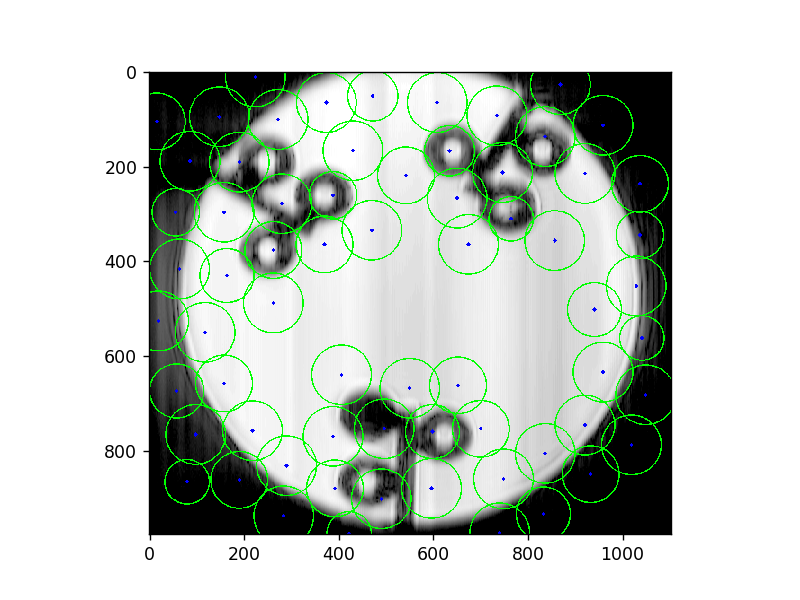

In [16]:
us_circles = cv2.HoughCircles(arr2_rot[25], cv2.HOUGH_GRADIENT, 3, 100, param1=50, param2=30, minRadius=45, maxRadius=65)
cimg_us = draw_circles(arr2_rot[25], us_circles)
plt.imshow(cimg_us)

# Registration based on points

<IPython.core.display.Javascript object>


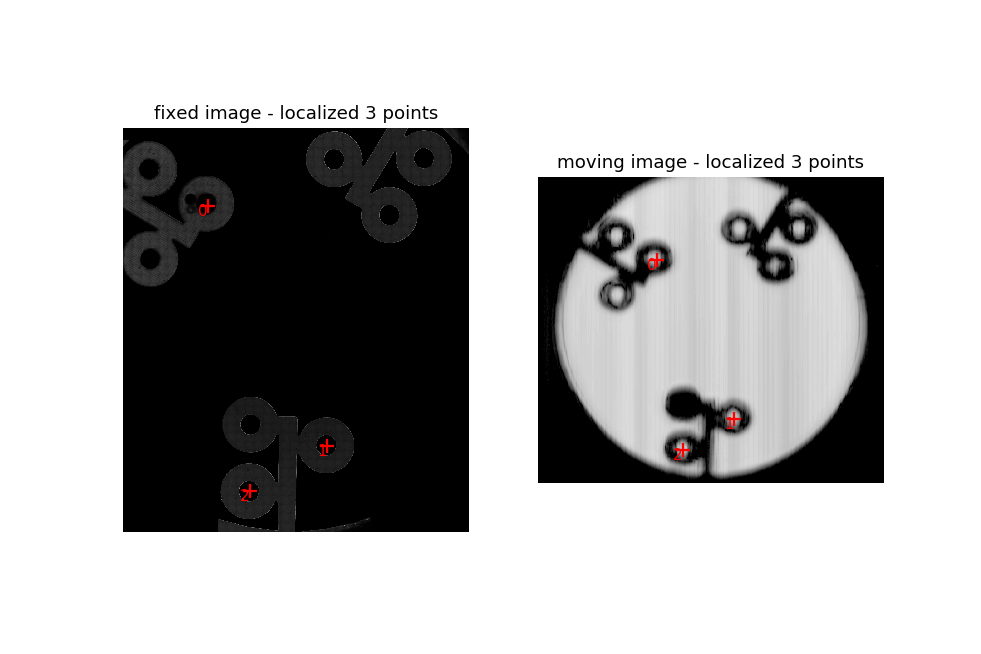

In [47]:
points = iplt.RegistrationPointDataAcquisition(mpm_image, us_fid)

In [48]:
fixed_image_points, moving_image_points = points.get_points_flat()
initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                                fixed_image_points, 
                                                                moving_image_points)
initial_transform.GetParameters()

(0.0, 0.0, 0.0022156736421540526, 3972.877227726906, 1872.6197985149697, 75.0)

In [50]:
initialized_image = sitk.Resample(us_fid, mpm_image, initial_transform, sitk.sitkLinear, 0.0, mpm_image.GetPixelID())

<IPython.core.display.Javascript object>


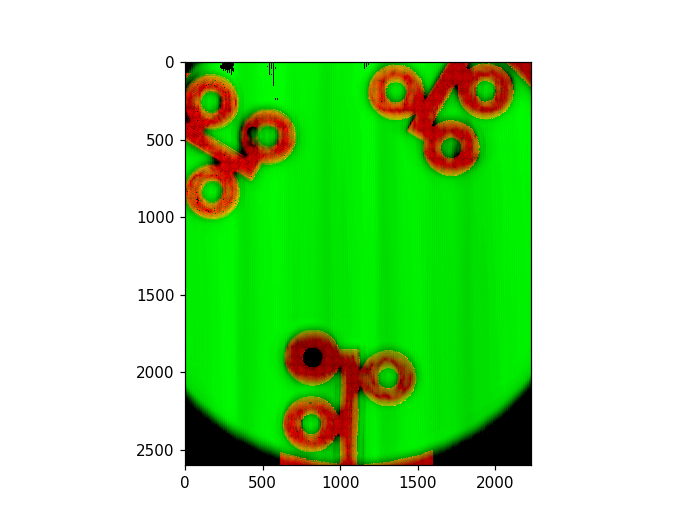

In [51]:
overlay = iplt.overlay_images(mpm_image, initialized_image, slice=3)
fig, ax = plt.subplots()
ax.imshow(overlay)

In [30]:
final_transform, metric, stop = reg.register(mpm_image, us_fid, initial_transform=initial_transform)
print(final_transform.GetParameters())
print(stop)
print(metric)

(-0.003415065333107215, 0.00327110863741018, -0.0005227486728265352, 3944.2287141666498, 1824.5041090522745, 491.0824433920935)
RegularStepGradientDescentOptimizerv4: Maximum number of iterations (100) exceeded.
-0.2818658132801083


In [52]:
initialized_image.GetOrigin()

(-9038.0, -9289.0, 0.0)

In [31]:
registered_image = sitk.Resample(us_fid, mpm_image, final_transform, sitk.sitkLinear, 0.0, mpm_image.GetPixelID())

In [49]:
us_fid.GetOrigin()

(-9967.0, -10033.16, 0.0)

In [44]:
registered_image.GetOrigin()

(-9038.0, -9289.0, 0.0)

<IPython.core.display.Javascript object>


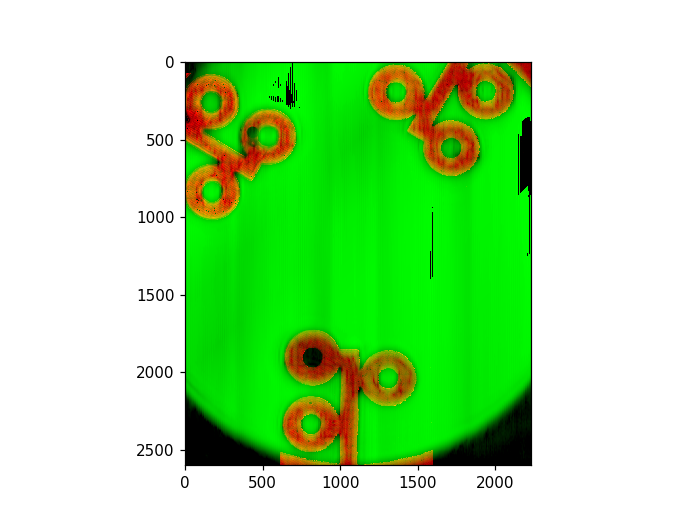

In [32]:
overlay_final = iplt.overlay_images(mpm_image, registered_image, slice=3)
fig2, ax2 = plt.subplots()
ax2.imshow(overlay_final)

In [33]:
print(final_transform.GetFixedParameters())

(-298.058566154233, 134.58120710684975, 25.0)


<IPython.core.display.Javascript object>


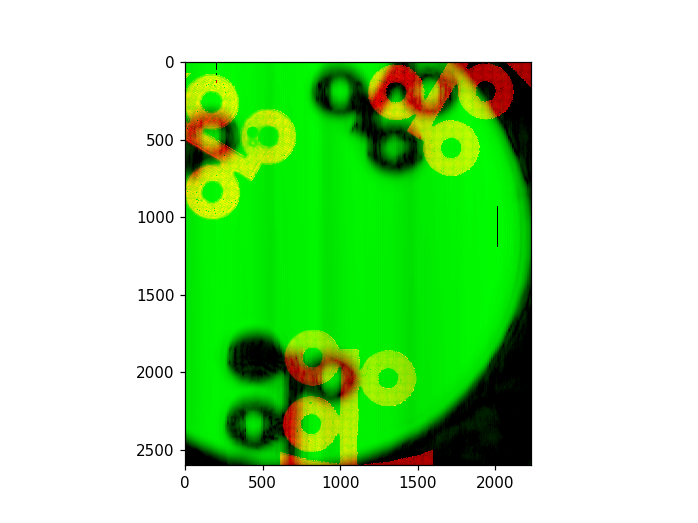

In [54]:
mpm_image.SetOrigin([-9038, -9289, 0])
us_fid.SetOrigin([-9967-6944, -10033.16-1824, -300])
# mpm_image.SetOrigin([-4053, 4370, 0])
# us_fid.SetOrigin([-9967+1039, -10033+11833, 0])
# us_fid.SetOrigin([-9967-6400+7422+4607, -10033.16+11833+12049, 0+505+25])
overlay = iplt.overlay_images(mpm_image, sitk.Resample(us_fid, mpm_image, sitk.Transform(), sitk.sitkLinear, 0.0, us_fid.GetPixelID()), slice=3)
fig, ax = plt.subplots()
ax.imshow(overlay)

In [ ]:
mpm_resampled = sitk.Resample(mpm_image, us_fid, sitk.AffineTransform(3), sitk.sitkNearestNeighbor, 0.0, mpm_image.GetPixelID())
iplt.MultiImageDisplay(image_list=[us_fid, mpm_resampled])

In [ ]:
final_transform.GetFixedParameters()

# Segmentation?

In [ ]:
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(us_fid).flatten(), bins=100)
plt.show()

In [ ]:
threshold_filters = {'Otsu': sitk.OtsuThresholdImageFilter(),
                     'Triangle' : sitk.TriangleThresholdImageFilter(),
                     'Huang' : sitk.HuangThresholdImageFilter(),
                     'MaxEntropy' : sitk.MaximumEntropyThresholdImageFilter()}

filter_selection = 'Otsu'
try:
  thresh_filter = threshold_filters[filter_selection]
  thresh_filter.SetInsideValue(0)
  thresh_filter.SetOutsideValue(1)
  thresh_img = thresh_filter.Execute(us_fid)
  thresh_value = thresh_filter.GetThreshold()
except KeyError:
  thresh_value = 120
  thresh_img = us_fid >thresh_value

print("Threshold used: " + str(thresh_value))    
iplt.MultiImageDisplay(image_list = [sitk.LabelOverlay(us_fid, thresh_img)],                   
                      title_list = ['Binary Segmentation'], figure_size=(8,4));

In [ ]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(sitk.ConnectedComponent(thresh_img))

# Look at the distribution of sizes of connected components (bacteria).
label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 1]

plt.figure()
plt.hist(label_sizes,bins=20)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()

In [ ]:
cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(thresh_img, [10, 10, 4])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [10, 10, 4])


In [ ]:
iplt.MultiImageDisplay(image_list = [sitk.LabelOverlay(us_fid, sitk.ConnectedComponent(thresh_img))])

In [ ]:
connected = sitk.ConnectedComponent(thresh_img)

In [ ]:
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(connected)

intensity_stats = sitk.LabelIntensityStatisticsImageFilter()
intensity_stats.Execute(connected,us_fid) 

In [ ]:
stats_list = [ (shape_stats.GetPhysicalSize(i),
               shape_stats.GetElongation(i),
               shape_stats.GetFlatness(i),
               shape_stats.GetOrientedBoundingBoxSize(i)[0],
               shape_stats.GetOrientedBoundingBoxSize(i)[2],
               intensity_stats.GetMean(i),
               intensity_stats.GetStandardDeviation(i),
               intensity_stats.GetSkewness(i)) for i in shape_stats.GetLabels()]
cols=["Volume (nm^3)",
      "Elongation",
      "Flatness",
      "Oriented Bounding Box Minimum Size(nm)",
      "Oriented Bounding Box Maximum Size(nm)",
     "Intensity Mean",
     "Intensity Standard Deviation",
     "Intensity Skewness"]

# Create the pandas data frame and display descriptive statistics.
stats = pd.DataFrame(data=stats_list, index=shape_stats.GetLabels(), columns=cols)
stats[stats['Volume (nm^3)'] < 1E8].describe()
stats = stats[stats['Volume (nm^3)'] < 1E8]

In [ ]:
fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(6,4*len(cols)))
axes[0,0].axis('off')

stats.loc[:,cols[0]].plot.hist(ax=axes[0,1], bins=25)
axes[0,1].set_xlabel(cols[0])
axes[0,1].xaxis.set_label_position("top")

for i in range(1,len(cols)):
    c = cols[i]
    bar = stats.loc[:,[c]].plot.hist(ax=axes[i,0], bins=20,orientation='horizontal',legend=False)
    bar.set_ylabel(stats.loc[:,[c]].columns.values[0])    
    scatter = stats.plot.scatter(ax=axes[i,1],y=c,x=cols[0])
    scatter.set_ylabel('')
    # Remove axis labels from all plots except the last (they all share the labels)
    if(i<len(cols)-1):
        bar.set_xlabel('')
        scatter.set_xlabel('')
# Adjust the spacing between plot columns and set the plots to have a tight
# layout inside the figure.
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()

In [ ]:
bacteria_labels = shape_stats.GetLabels()
bacteria_volumes = [shape_stats.GetPhysicalSize(label) for label in bacteria_labels] 
num_images = 5 # number of bacteria images we want to display

bacteria_labels_volume_sorted = [label for _,label in sorted(zip(bacteria_volumes, bacteria_labels))]

resampler = sitk.ResampleImageFilter()
aligned_image_spacing = [10,10,10] #in nanometers

start = np.ceil(np.size(bacteria_labels_volume_sorted)/2)

for label in bacteria_labels_volume_sorted[start:start+num_images]:
    aligned_image_size = [ int(math.ceil(shape_stats.GetOrientedBoundingBoxSize(label)[i]/aligned_image_spacing[i])) for i in range(3) ]
    direction_mat = shape_stats.GetOrientedBoundingBoxDirection(label)
    aligned_image_direction = [direction_mat[0], direction_mat[3], direction_mat[6], 
                               direction_mat[1], direction_mat[4], direction_mat[7],
                               direction_mat[2], direction_mat[5], direction_mat[8] ] 
    resampler.SetOutputDirection(aligned_image_direction)
    resampler.SetOutputOrigin(shape_stats.GetOrientedBoundingBoxOrigin(label))
    resampler.SetOutputSpacing(aligned_image_spacing)
    resampler.SetSize(aligned_image_size)
    
    obb_img = resampler.Execute(us_fid)
    # Change the image axes order so that we have a nice display.
    obb_img = sitk.PermuteAxes(obb_img,[2,1,0])
    iplt.MultiImageDisplay(image_list = [obb_img],                   
                          title_list = ["OBB_{0}".format(label)])

# Height finding

In [ ]:
iplt.MultiImageDisplay(image_list=[us_image2_windowed])

In [ ]:
us_edges = cv2.Canny(arr2[177], 50, 150)


In [ ]:
lines = cv2.HoughLines(us_edges, 1, np.pi/180, 200, 100)
np.shape(lines)

In [ ]:
cimg_lines = draw_lines(arr2[529], lines)
plt.imshow(cimg_lines)

In [ ]:
plt.imshow(arr2[529])

In [ ]:
help(cv2.HoughLines)

In [ ]:
point_height = 214